## Overview
---
Reversible reactions do not present any special challenge if the chemical system is well stirred, because we can model is by using two separate reactions.

The situation is trivial if we adopt compartment-based model of diffusion. **It needs more considerations when we adopt the molecular-based model**. Let's consider the following reversible reaction:

$$
A+B\overset{k_1}{\underset{k_2}{\leftrightarrow}}C
$$

This reaction can be represented as:

$$
A+B\overset{k_1}{\rightarrow}C\text{---(1)}
$$
$$
A+B\overset{k_2}{\leftarrow}C\text{---(2)}
$$

There is no problem to model (1). The key questions, how to place newly-introduced $A$ and $B$?

If we are using $\lambda-\bar{\varrho}$ model, the one discussed in notebook (6.4), then it is safe to **initialize the positions of new molecules of A and B at the position of the complex C, since there is only a finite (and often small) probability that A and B
will react in the next time step.** Otherwise, we might need to introduce an **unbinding distance** between the new $A$ and $B$.

## reversible reactions with receptors on the domain boundary

Molecule of $A$ and receptor molecule $B$(on the boundary) react according to the reversible second-order reaction:
$$
A+B\overset{k_1}{\underset{k_3}{\leftrightarrow}}\bar{A B}\text{---(3)}
$$

We consider the chemical species $A$ diffusing in the domain $[0, L] \times[0, \bar{L}] \times[0, \bar{L}] .$ The boundary $x=0$ is uniformly covered by receptors $B .$ Since the receptors are uniformly distributed on the boundary, there will be no concentration differences (on average) in the y- and z-directions. Thus, we focus only on the behaviour along the x-axis. We study the behaviour of molecules in the one-dimensional interval $[0, L]$ with the reversible reactive boundary condition at $x=0$ and the reflective boundary condition at $x=L .$ Whenever a molecule hits the boundary, it is adsorbed with probability $P_2(\Delta t)$ given by:
$$
P_{2}(\Delta t)=\frac{\sigma \sqrt{\pi \Delta t}}{\sqrt{D}}\text{---(4)}
$$
and otherwise it is reflected. The justification of (4) can be found in [Erban and Chapman (2007)](https://iopscience.iop.org/article/10.1088/1478-3975/4/1/003).

The implementation of B.C. is given by the following two steps:

1. If $X(t+\Delta t)$ computed by ( 6.30) is negative then $X(t+\Delta t)=-X(t)-\sqrt{2 D \Delta t} \xi$ with probability $1-P_{2}(\Delta t)$ otherwise the molecule reacts with the boundary.

2. If $X(t+\Delta t)$ computed by ( 6.30) is positive then the molecule reacts with the boundary with probability $\exp [-X(t) X(t+\Delta t) /(D \Delta t)] P_{2}(\Delta t)$

At the end of each time step, we also have to generate one random number $r$ uniformly distributed in $(0,1)$ for each complex $\overline{A B}$. If $r<k_{2} \Delta t,$ then the corresponding complex dissociates and we introduce a new molecule of $A$ in position $x=0$ to the solution.

> We note that this algorithm will work correctly provided that $P_2(\Delta t)$ is small. Otherwise, **the molecule of A at the position x = 0 might react immediately with the receptor B**. 

## Implementation of Molecule Diffusion with Reaction (3) as B.C.

The following compartment-based code simulates the reaction(3) on the boundary $x=0$.

At the beginning, 10000 molecules are uniformly distributed in $[0,L/2]$. The simulation time is 10 min. The absorbing boundary has unit area. We use: $\sigma=k_1b=2\times10^{-3}mm sec^{-1}$,$k_2=5\times10^{-3} sec^{-1}$, $D=10^{-4}mm^2sec^{-1}$, $L=1mm$,$K=40$

In [17]:
import numpy as np
from numpy.random import uniform

def evolve1D(sigma,b,k2,D,length,nc,n0,ttot):
    d = D/(length/nc)**2
    t = 0
    alst = np.zeros(nc,dtype=int)
    alst[:nc//2]=n0/(nc//2)
    fw = [k2*b]+d*alst[:-1] 
    # first propensity: production of A
    bk = [sigma*alst[0]]+d*alst[1:]
    # first propensity: degradation of A
    s = 0
    while t<ttot:
        al0 = np.sum(fw)+np.sum(bk)
        r1,r2 = uniform(size=2)
        tau = 1/al0*np.log(1/r1)
        t += tau
        plst = np.cumsum(fw+bk)/al0
        res = int(np.sum(plst<r2))
        if res==0:
            alst[0]+=1
        elif res==nc and alst[0]>0:
            alst[0]-=1
        elif 0<res<nc and alst[res-1]>0:
            alst[res-1]-=1
            alst[res]+=1
        elif alst[res-nc]>0:
            alst[res-nc]-=1
            alst[res-nc-1]+=1
        s+=1
        if s%1000==0:
            print('At {} step,time:{}'.format(s,t))
        fw = [k2*b]+d*alst[:-1]
        bk = [sigma*alst[0]]+d*alst[1:]
        
    return alst

In [20]:
Sigma = 0.002
B = 1
K2 = 0.005
D = 0.0004
L = 1
K = 40
N0 = 100
T = 15
cts = evolve1D(Sigma,B,K2,D,L,K,N0,T)

At 1000 step,time:5.496131840291373
At 2000 step,time:7.627142562302253
At 3000 step,time:8.531241814424671
At 4000 step,time:9.185176687084503
At 5000 step,time:9.61030509211515
At 6000 step,time:9.984901039340585
At 7000 step,time:10.262715617892448
At 8000 step,time:10.508853792867384
At 9000 step,time:10.721700918730173
At 10000 step,time:10.916611286715794
At 11000 step,time:11.090501566516041
At 12000 step,time:11.241927669213041
At 13000 step,time:11.380438758434606
At 14000 step,time:11.50544300549083
At 15000 step,time:11.627004755299156
At 16000 step,time:11.735843253450911
At 17000 step,time:11.834645416848169
At 18000 step,time:11.928039083904075
At 19000 step,time:12.019067773653369
At 20000 step,time:12.107016089075525
At 21000 step,time:12.189452231928302
At 22000 step,time:12.262836426800426
At 23000 step,time:12.339389932686323
At 24000 step,time:12.413286109173294
At 25000 step,time:12.48065678512378
At 26000 step,time:12.544291110311006
At 27000 step,time:12.60437637

Text(0, 0.5, 'count')

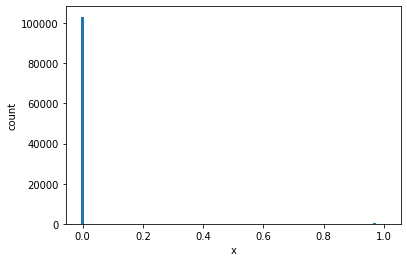

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

xs = np.round(np.linspace(0,1,K),2)
plt.bar(xs,cts.tolist(),width=0.01)
plt.xlabel('x')
plt.ylabel('count')